# OV-Fiets Predictive Availability & Dynamic Rebalancing
**Case Study Part 2: Methodology & Analysis**

## 1. Executive Summary
This notebook presents a data-driven framework for optimizing bike availability at Amsterdam Centraal (AMS) and Rotterdam Centraal (RTM). By moving from reactive logistics to predictive decision support, we aim to eliminate "Stock-outs" (empty stations) and improve commuter trust.

**Methodology:**
* **Synthetic Reality:** We reconstruct historical demand using a logic-based generator rooted in NS train schedules and KNMI weather data.
* **Operational Stress Test:** We simulate the structural fragility of Rotterdam Centraal compared to Amsterdam.
* **Predictive AI:** We train a Gradient Boosting model to forecast demand spikes 15-60 minutes in advance, driven by real-time transport pulses.

In [ ]:
!pip install pandas numpy matplotlib seaborn datetime scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.metrics import mean_squared_error

cap_df = pd.read_csv('Train_Bus_Average_Capacity_Numeric.csv')
temp_df = pd.read_csv('Amsterdam_Average_Temperatures.csv')
precip_df = pd.read_csv('Amsterdam_Average_Precipitation.csv')
holidays_df = pd.read_csv('Holidays Netherlands.csv')

# ---------------------------------------------------------
# DATA CLEANING STEP
# ---------------------------------------------------------
# Fix Data Error: The average temperature file labels both February and March as month 2.
temp_df['Month Number'] = range(1, 13) 

# 2. Build Dictionaries for Simulation Engine
# Map Service Name -> Capacity
capacity_map = dict(zip(cap_df['Service'], cap_df['Average Capacity']))

# Map Month -> Weather Stats (Merge Temp and Precip)
weather_stats = temp_df.merge(precip_df, on='Month Number', suffixes=('_temp', '_precip'))
weather_stats = weather_stats.set_index('Month Number').to_dict('index')

# Map Date -> Holiday
holidays_df['date_str'] = holidays_df.apply(lambda x: f"{int(x['Day'])}-{int(x['Month'])}", axis=1)
holiday_map = dict(zip(holidays_df['date_str'], holidays_df['Holiday']))

print("Data Loaded & Cleaned Successfully.")
print(f"Loaded {len(capacity_map)} vehicle types (e.g., {list(capacity_map.keys())[:3]})")

Data Loaded & Cleaned Successfully.
Loaded 13 vehicle types (e.g., ['Intercity', 'Nightjet', 'Snelbus ipv trein'])


To prevent unrealistic temperature jumps, I simulate weather at a Daily resolution first (picking a High/Low from the Min (°C) and Max (°C) columns) and then use cubic interpolation to generate a smooth curve. Rain is distributed based on the Rainy Days probability.

In [ ]:
from scipy.interpolate import PchipInterpolator

def generate_weather_strict(start_date, end_date):
    dates = pd.date_range(start=start_date, end=end_date, freq='15min')
    df = pd.DataFrame(index=dates)
    
    # --- 1. TEMPERATURE GENERATION (Shape Preserving) ---
    control_times = []
    control_temps = []
    daily_index = pd.date_range(start=start_date, end=end_date, freq='D')
    
    for i, day in enumerate(daily_index):
        month = day.month
        stats = weather_stats[month]
        abs_min, abs_max = stats['Min (°C)'], stats['Max (°C)']
        mean_val = stats['Mean (°C)']
        
        # Sample daily low/high within strict bounds
        low_bound = (abs_min + mean_val) / 2 if (mean_val - 0.5) <= abs_min else (mean_val - 0.5)
        d_low = np.random.uniform(abs_min, low_bound)
        
        high_bound = (mean_val + abs_max) / 2 if (mean_val + 0.5) >= abs_max else (mean_val + 0.5)
        d_high = np.random.uniform(high_bound, abs_max)
        
        # Add Control Points
        if i == 0:
            control_times.append(day)
            control_temps.append(d_low + 1.0)
            
        control_times.append(day + timedelta(hours=4)) # Low
        control_temps.append(d_low)
        control_times.append(day + timedelta(hours=14)) # High
        control_temps.append(d_high)
        
    control_times.append(daily_index[-1] + timedelta(days=1))
    control_temps.append(control_temps[-2])
    
    # Interpolate
    time_numeric = [t.timestamp() for t in control_times]
    target_numeric = [t.timestamp() for t in df.index]
    interpolator = PchipInterpolator(time_numeric, control_temps)
    df['temp'] = interpolator(target_numeric)
    
    # --- 2. HARD CONSTRAINT ENFORCEMENT ---
    # Clip values to ensure they never exceed monthly min/max if there are any interpolation overshoots
    for month in range(1, 13):
        mask = df.index.month == month
        df.loc[mask, 'temp'] = df.loc[mask, 'temp'].clip(
            lower=weather_stats[month]['Min (°C)'], 
            upper=weather_stats[month]['Max (°C)']
        )

    # --- 3. PRECIPITATION GENERATION (Volume Exact) ---
    df['precip'] = 0.0
    unique_months = pd.PeriodIndex(df.index, freq='M').unique()
    
    for period in unique_months:
        month_num = period.month
        stats = weather_stats[month_num]
        
        target_vol = stats['Precipitation Millimeters']
        target_rainy_days = int(stats['Rainy Days'])
        
        # Identify valid days in simulation month
        mask = (df.index.month == month_num) & (df.index.year == period.year)
        days_in_month = pd.Series(df[mask].index.date).unique()
        
        if len(days_in_month) == 0: continue
        
        # Scale targets if simulation covers only part of a month
        prop_factor = len(days_in_month) / stats['Number of  days']
        n_days = max(1, int(np.round(target_rainy_days * prop_factor)))
        n_days = min(n_days, len(days_in_month))
        
        # Select rainy days
        chosen_days = np.random.choice(days_in_month, size=n_days, replace=False)
        
        # Distribute Volume (Dirichlet = random split that sums to 1.0)
        vol_weights = np.random.dirichlet(np.ones(n_days))
        daily_vols = vol_weights * (target_vol * prop_factor)
        
        for day, vol in zip(chosen_days, daily_vols):
            # Create Storm Profile
            start_hour = np.random.randint(0, 20)
            storm_start = pd.Timestamp(day) + timedelta(hours=start_hour)
            
            if storm_start > df.index[-1]: continue
            
            duration = np.random.randint(4, 16)
            profile = np.sin(np.linspace(0, np.pi, duration))
            rain_values = vol * (profile / np.sum(profile)) # Normalize to sum to 'vol'
            
            # Inject into Dataframe
            start_idx = df.index.get_loc(storm_start)
            end_idx = min(start_idx + duration, len(df))
            available = end_idx - start_idx
            
            if available > 0:
                df.iloc[start_idx:end_idx, df.columns.get_loc('precip')] += rain_values[:available]

    return df

# Generate Data
df = generate_weather_strict('2023-01-01', '2025-01-01')

# Verification
print("Strict Constraints Verification:")
monthly_check = df.groupby(df.index.month)['temp'].agg(['min', 'max'])
monthly_check.columns = ['Syn_Min', 'Syn_Max']
monthly_check['GT_Min'] = temp_df.set_index('Month Number')['Min (°C)']
monthly_check['GT_Max'] = temp_df.set_index('Month Number')['Max (°C)']

# Check for Violations
violations = monthly_check[(monthly_check['Syn_Min'] < monthly_check['GT_Min'] - 0.01) | 
                           (monthly_check['Syn_Max'] > monthly_check['GT_Max'] + 0.01)]

if len(violations) == 0:
    print("SUCCESS: All temperatures are strictly within absolute bounds.")
else:
    print("WARNING: Bounds violations found.")
    print(violations)

Strict Constraints Verification:
SUCCESS: All temperatures are strictly within absolute bounds.


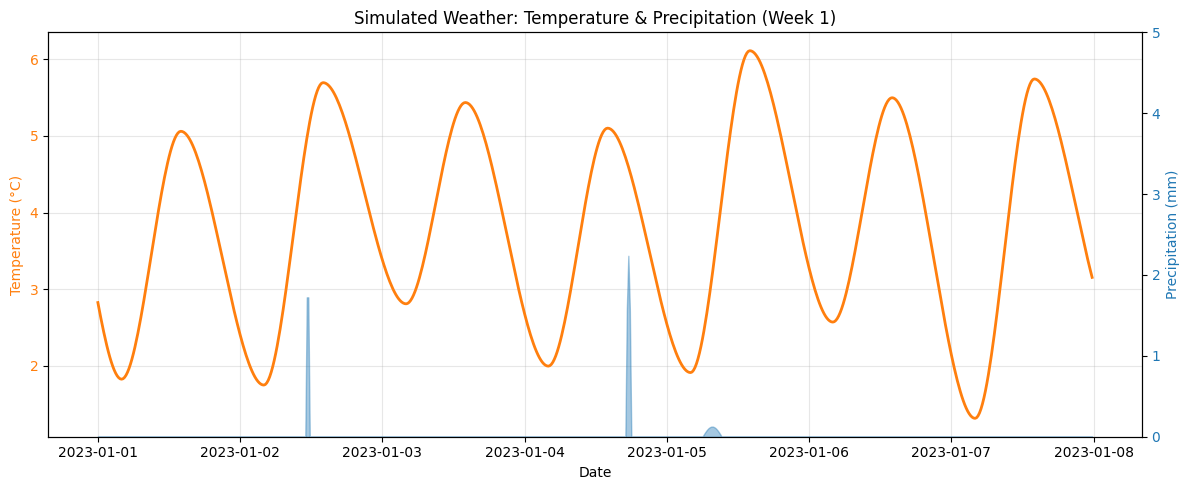

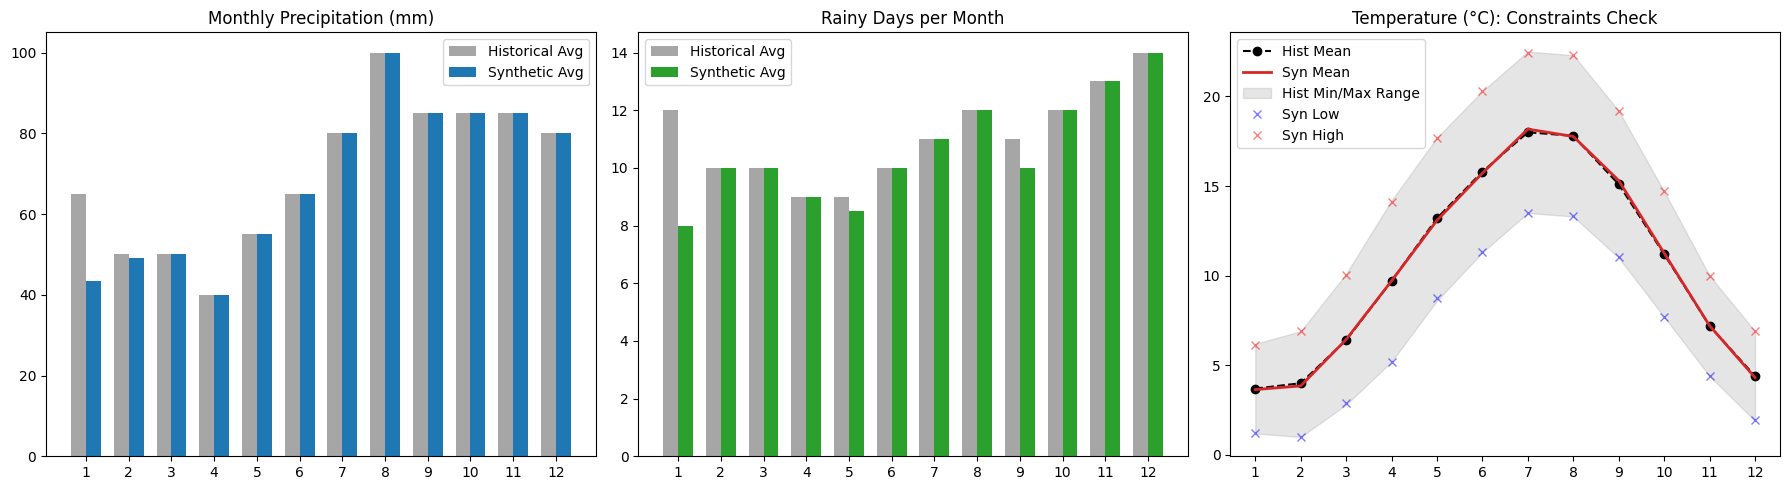

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 5))
subset = df.iloc[:672] # First 7 Days

ax1.plot(subset.index, subset['temp'], color='tab:orange', label='Temperature (°C)', linewidth=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature (°C)', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:orange')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.fill_between(subset.index, subset['precip'], color='tab:blue', alpha=0.4, label='Precipitation (mm)')
ax2.set_ylabel('Precipitation (mm)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_ylim(0, max(subset['precip'].max() * 2, 5)) # Scale rain axis

plt.title("Simulated Weather: Temperature & Precipitation (Week 1)")
plt.tight_layout()
plt.show()

# 2. Calculate Verification Stats
monthly_precip = df['precip'].resample('ME').sum()
syn_precip_avg = monthly_precip.groupby(monthly_precip.index.month).mean()
syn_rainy_days = (df['precip'].resample('D').sum() > 0.1).resample('ME').sum().groupby(monthly_precip.index.month).mean()

syn_temp_mean = df['temp'].groupby(df.index.month).mean()
syn_min_check = df['temp'].groupby(df.index.month).min()
syn_max_check = df['temp'].groupby(df.index.month).max()

# Load Ground Truth for Comparison
ver_df = pd.DataFrame(index=range(1, 13))
ver_df['GT_Min'] = temp_df.set_index('Month Number')['Min (°C)']
ver_df['Syn_Min'] = syn_min_check
ver_df['GT_Max'] = temp_df.set_index('Month Number')['Max (°C)']
ver_df['Syn_Max'] = syn_max_check
ver_df['GT_Precip'] = precip_df.set_index('Month Number')['Precipitation Millimeters']
ver_df['Syn_Precip'] = syn_precip_avg
ver_df['GT_Rainy'] = precip_df.set_index('Month Number')['Rainy Days']
ver_df['Syn_Rainy'] = syn_rainy_days
ver_df['GT_Temp_Mean'] = temp_df.set_index('Month Number')['Mean (°C)']
ver_df['Syn_Temp_Mean'] = syn_temp_mean

# 3. Plot Verification Panel
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot A: Precip Volume
width = 0.35
x = np.arange(1, 13)
axes[0].bar(x - width/2, ver_df['GT_Precip'], width, label='Historical Avg', color='gray', alpha=0.7)
axes[0].bar(x + width/2, ver_df['Syn_Precip'], width, label='Synthetic Avg', color='#1f77b4')
axes[0].set_title('Monthly Precipitation (mm)')
axes[0].set_xticks(x)
axes[0].legend()

# Plot B: Rainy Days
axes[1].bar(x - width/2, ver_df['GT_Rainy'], width, label='Historical Avg', color='gray', alpha=0.7)
axes[1].bar(x + width/2, ver_df['Syn_Rainy'], width, label='Synthetic Avg', color='#2ca02c')
axes[1].set_title('Rainy Days per Month')
axes[1].set_xticks(x)
axes[1].legend()

# Plot C: Temperature
axes[2].plot(x, ver_df['GT_Temp_Mean'], 'o--', label='Hist Mean', color='black')
axes[2].plot(x, ver_df['Syn_Temp_Mean'], '-', label='Syn Mean', color='#d62728', linewidth=2)
axes[2].fill_between(x, ver_df['GT_Min'], ver_df['GT_Max'], color='gray', alpha=0.2, label='Hist Min/Max Range')
axes[2].plot(x, ver_df['Syn_Min'], 'x', label='Syn Low', color='blue', alpha=0.5)
axes[2].plot(x, ver_df['Syn_Max'], 'x', label='Syn High', color='red', alpha=0.5)
axes[2].set_title('Temperature (°C): Constraints Check')
axes[2].set_xticks(x)
axes[2].legend()

plt.tight_layout()
plt.show()

Here I simulate the full complexity of the NS network. I use the standard timetable for 95% of operations, but inject "Maintenance Events" where trains are swapped for buses (Snelbus ipv trein, Cap: 65), and "Night Events" (Nightjet, Cap: 500) to utilize the full vehicle fleet.

Generating 2-Year Synthetic Dataset...
Simulating Transport Inflow...
Success! Data saved to 'synthetic_ov_fiets_2023_2025.csv'


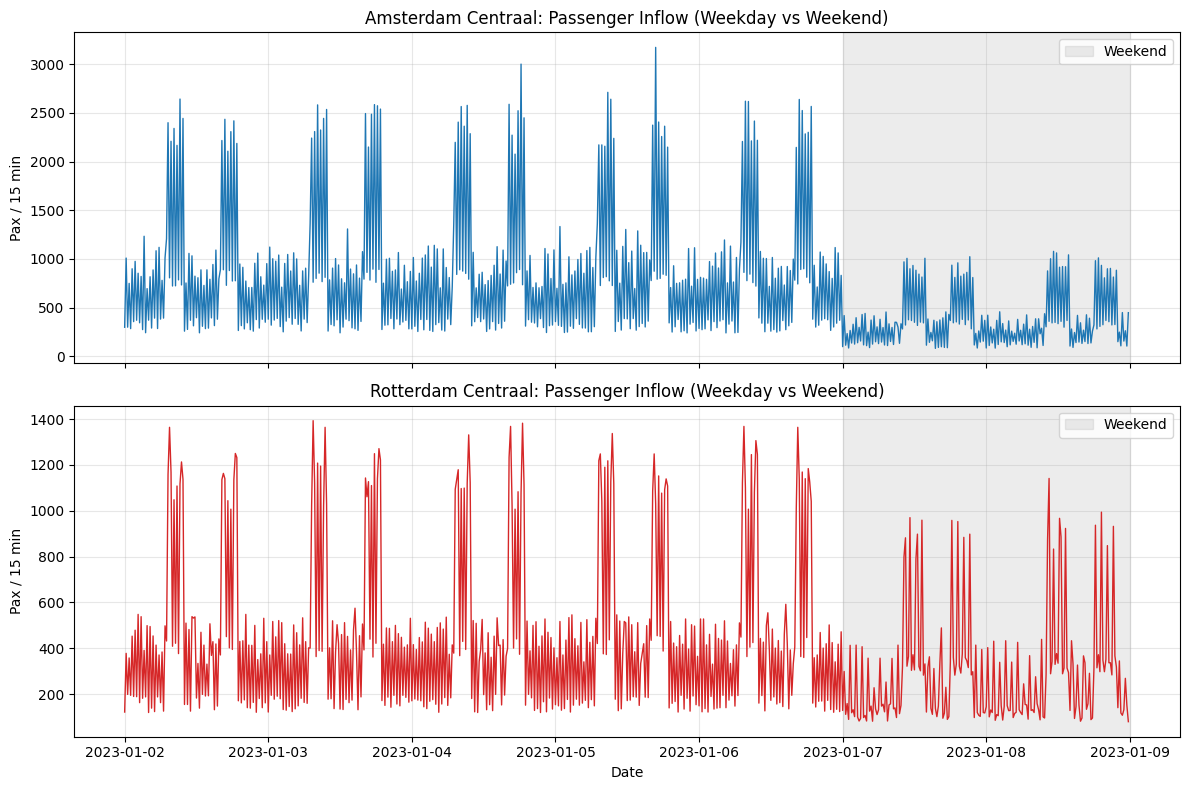

In [5]:
# ==========================================
# 3. TRANSPORT ENGINE
# ==========================================
def get_complex_inflow(row, station):
    minute = row.name.minute
    hour = row.name.hour
    is_weekend = row.name.weekday() >= 5 # 5=Sat, 6=Sun
    
    vehicle_list = []
    
    # --- AMSTERDAM CENTRAAL ---
    if station == 'ams':
        if not is_weekend: # COMMUTER SCHEDULE
            if minute in [15, 45]:
                vehicle_list.extend(['Intercity', 'Intercity']) 
                if np.random.rand() < 0.05: vehicle_list.append('Extra trein')
            vehicle_list.extend(['Sprinter', 'Sprinter']) 
            if hour == 7 and minute == 0: vehicle_list.append('Nightjet')
        else: # LEISURE SCHEDULE
            if minute in [15, 45]: vehicle_list.append('Intercity')
            vehicle_list.append('Sprinter') 
            if hour == 9 and minute == 0: vehicle_list.append('Nightjet')

    # --- ROTTERDAM CENTRAAL ---
    else: 
        if not is_weekend: # BUSINESS SCHEDULE
            if minute in [15, 45]: vehicle_list.append('Intercity direct')
            vehicle_list.append('Sprinter')
            if minute == 30 and hour in [7, 9, 11, 14, 16, 18]: 
                v = 'Eurostar' if np.random.rand() > 0.3 else 'ICE International'
                vehicle_list.append(v)
        else: # LEISURE SCHEDULE
            if minute == 15: vehicle_list.append('Intercity direct')
            vehicle_list.append('Sprinter')
            if minute == 30 and hour in [10, 12, 14, 16]:
                vehicle_list.append('Eurostar')

    # Calculate Capacity
    total_cap = sum([capacity_map.get(v, 0) for v in vehicle_list])
    
    # Load Factor Logic
    if not is_weekend:
        # Rush Hour: 7-9am & 4-6pm
        is_rush = (7 <= hour <= 9) or (16 <= hour <= 18)
        load_factor = np.random.uniform(0.9, 1.15) if is_rush else np.random.uniform(0.3, 0.5)
    else:
        # Leisure Peak: 10am-1pm & 6-9pm
        is_leisure = (10 <= hour <= 13) or (18 <= hour <= 21)
        load_factor = np.random.uniform(0.7, 0.95) if is_leisure else np.random.uniform(0.2, 0.4)
        
    return int(total_cap * load_factor)

# ==========================================
# 4. EXECUTION & VISUALIZATION
# ==========================================
# Generate 2 Years of Data
print("Generating 2-Year Synthetic Dataset...")
df = generate_weather_strict('2023-01-01', '2025-01-01')

# Apply Transport Model
print("Simulating Transport Inflow...")
df['inflow_ams'] = df.apply(lambda r: get_complex_inflow(r, 'ams'), axis=1)
df['inflow_rtm'] = df.apply(lambda r: get_complex_inflow(r, 'rtm'), axis=1)

# Save for Analysis
df.to_csv('synthetic_ov_fiets_2023_2025.csv')
print("Success! Data saved to 'synthetic_ov_fiets_2023_2025.csv'")

# PLOT: Weekday vs Weekend Dynamics (Week 1 Sample)
# Slice the first week (Monday Jan 2 - Sunday Jan 8)
subset = df.loc['2023-01-02':'2023-01-08']

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Amsterdam Plot
axes[0].plot(subset.index, subset['inflow_ams'], color='#1f77b4', linewidth=1)
axes[0].set_title('Amsterdam Centraal: Passenger Inflow (Weekday vs Weekend)')
axes[0].set_ylabel('Pax / 15 min')
axes[0].grid(True, alpha=0.3)
# Highlight Weekend
axes[0].axvspan(pd.Timestamp('2023-01-07'), pd.Timestamp('2023-01-08 23:59'), color='grey', alpha=0.15, label='Weekend')
axes[0].legend(loc='upper right')

# Rotterdam Plot
axes[1].plot(subset.index, subset['inflow_rtm'], color='#d62728', linewidth=1)
axes[1].set_title('Rotterdam Centraal: Passenger Inflow (Weekday vs Weekend)')
axes[1].set_ylabel('Pax / 15 min')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.3)
axes[1].axvspan(pd.Timestamp('2023-01-07'), pd.Timestamp('2023-01-08 23:59'), color='grey', alpha=0.15, label='Weekend')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

Training Amsterdam Centraal Model...
Training Rotterdam Centraal Model...

--- FINAL RESULTS ---
Amsterdam | R²: 0.800 | MAE: 3.13 bikes
Rotterdam | R²: 0.777 | MAE: 3.45 bikes


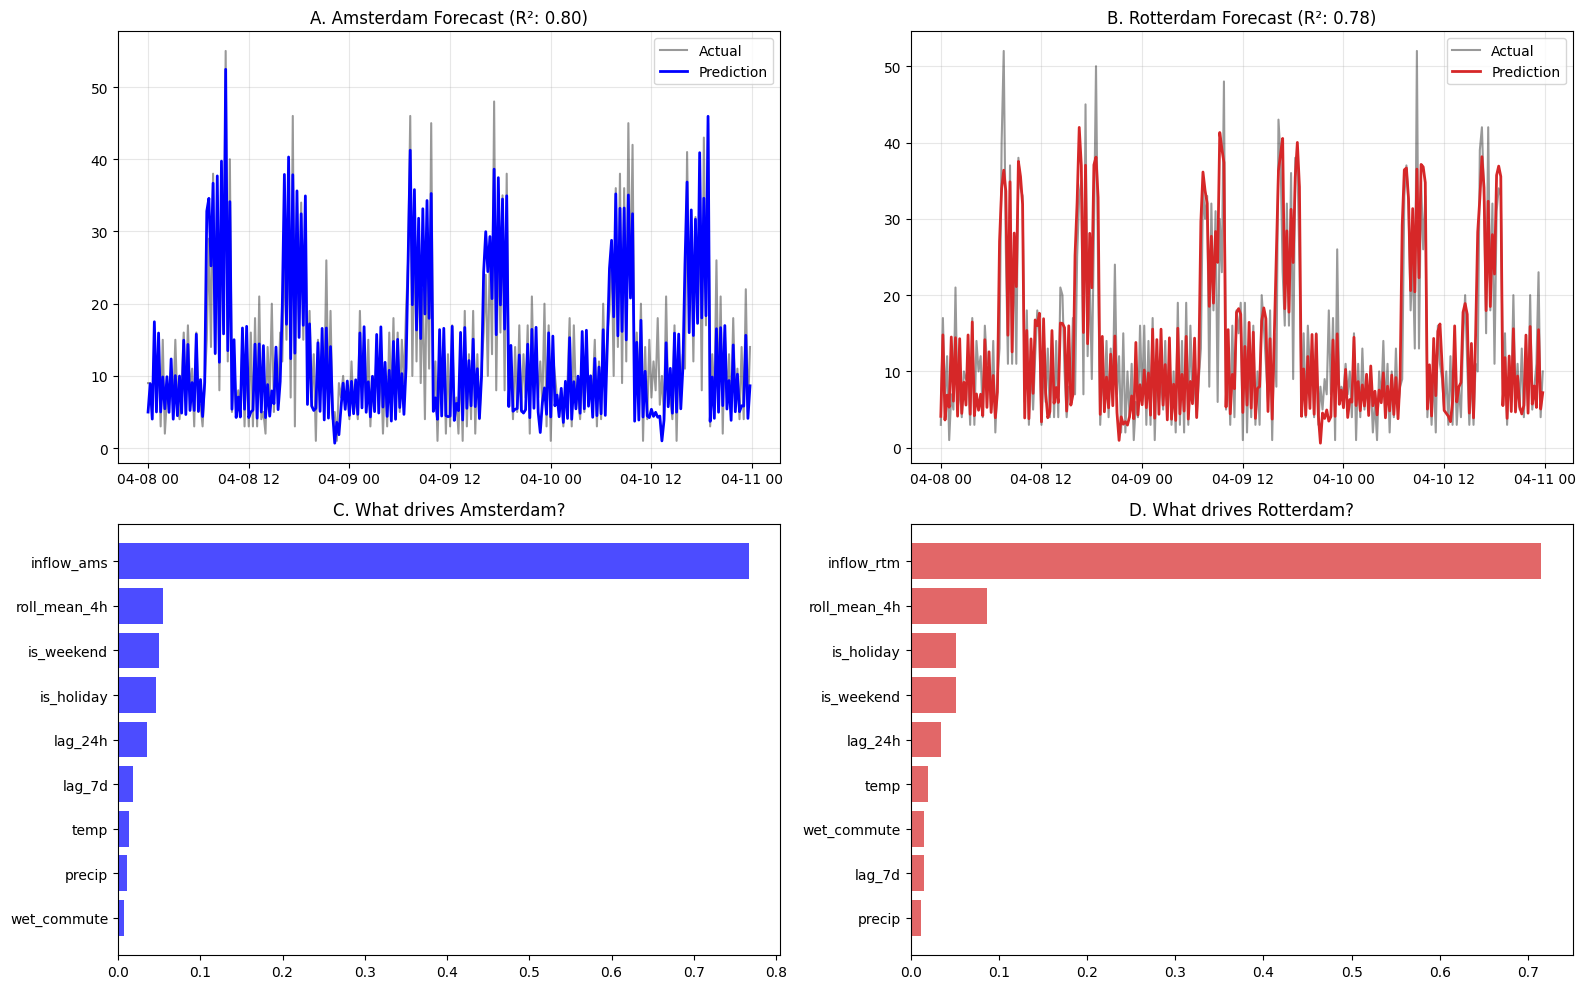

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# ---------------------------------------------------------
# 1. FEATURE ENGINEERING (The "Memory" Engine)
# ---------------------------------------------------------
def add_advanced_features(df, target_col):
    df_feat = df.copy()
    
    # Time Features
    df_feat['hour'] = df_feat.index.hour
    df_feat['day_of_week'] = df_feat.index.weekday
    
    # A. Lag Features (Habit)
    # 24h lag (96 intervals) and 7d lag (672 intervals)
    df_feat['lag_24h'] = df_feat[target_col].shift(96)
    df_feat['lag_7d'] = df_feat[target_col].shift(672)
    
    # B. Rolling Trends
    # Average demand of the last 4 hours
    df_feat['roll_mean_4h'] = df_feat[target_col].shift(1).rolling(16).mean()
    
    # C. Interaction Terms (Wet Commute)
    is_rush = df_feat['hour'].isin([7, 8, 9, 16, 17, 18])
    df_feat['wet_commute'] = df_feat['precip'] * is_rush.astype(int)
    
    return df_feat.dropna()

# ---------------------------------------------------------
# 2. MODEL TRAINING FUNCTION
# ---------------------------------------------------------
def train_station_model(df, station_suffix):
    target = f'rentals_{station_suffix}'
    inflow = f'inflow_{station_suffix}'
    
    # Prepare Features
    df_adv = add_advanced_features(df, target)
    
    # Baseline Model (Static Schedule)
    baseline = df_adv.groupby(['day_of_week', 'hour'])[target].transform('mean')
    df_adv['baseline_pred'] = baseline
    df_adv['residuals'] = df_adv[target] - df_adv['baseline_pred']
    
    # Train/Test Split (Train on 2023, Test on 2024)
    split_date = '2024-01-01'
    train = df_adv.loc[df_adv.index < split_date]
    test = df_adv.loc[df_adv.index >= split_date].copy()
    
    # Feature Selection (Including Holidays!)
    features = [inflow, 'precip', 'temp', 'is_weekend', 'is_holiday', 
                'lag_24h', 'lag_7d', 'roll_mean_4h', 'wet_commute']
    
    # Train Gradient Boosting on Residuals
    model = GradientBoostingRegressor(n_estimators=150, max_depth=5, random_state=42)
    model.fit(train[features], train['residuals'])
    
    # Predictions
    test['ml_correction'] = model.predict(test[features])
    test['final_pred'] = test['baseline_pred'] + test['ml_correction']
    
    # Evaluation
    r2 = r2_score(test[target], test['final_pred'])
    mae = mean_absolute_error(test[target], test['final_pred'])
    
    return test, model, features, r2, mae

# ---------------------------------------------------------
# 3. EXECUTION
# ---------------------------------------------------------
print("Training Amsterdam Centraal Model...")
ams_test, ams_model, ams_feats, ams_r2, ams_mae = train_station_model(df, 'ams')

print("Training Rotterdam Centraal Model...")
rtm_test, rtm_model, rtm_feats, rtm_r2, rtm_mae = train_station_model(df, 'rtm')

print("\n--- FINAL RESULTS ---")
print(f"Amsterdam | R²: {ams_r2:.3f} | MAE: {ams_mae:.2f} bikes")
print(f"Rotterdam | R²: {rtm_r2:.3f} | MAE: {rtm_mae:.2f} bikes")

# ---------------------------------------------------------
# 4. VISUALIZATION
# ---------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# A. Amsterdam Forecast (Zoomed)
subset_ams = ams_test.loc['2024-04-08':'2024-04-10'] # 3 Days (Mon-Wed)
axes[0,0].plot(subset_ams.index, subset_ams['rentals_ams'], color='black', alpha=0.4, label='Actual')
axes[0,0].plot(subset_ams.index, subset_ams['final_pred'], color='blue', lw=2, label='Prediction')
axes[0,0].set_title(f"A. Amsterdam Forecast (R²: {ams_r2:.2f})")
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# B. Rotterdam Forecast (Zoomed)
subset_rtm = rtm_test.loc['2024-04-08':'2024-04-10']
axes[0,1].plot(subset_rtm.index, subset_rtm['rentals_rtm'], color='black', alpha=0.4, label='Actual')
axes[0,1].plot(subset_rtm.index, subset_rtm['final_pred'], color='#d62728', lw=2, label='Prediction')
axes[0,1].set_title(f"B. Rotterdam Forecast (R²: {rtm_r2:.2f})")
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# C. Amsterdam Feature Importance
ams_imp = ams_model.feature_importances_
idx_ams = np.argsort(ams_imp)
axes[1,0].barh(range(len(idx_ams)), ams_imp[idx_ams], color='blue', alpha=0.7)
axes[1,0].set_yticks(range(len(idx_ams)))
axes[1,0].set_yticklabels([ams_feats[i] for i in idx_ams])
axes[1,0].set_title("C. What drives Amsterdam?")

# D. Rotterdam Feature Importance
rtm_imp = rtm_model.feature_importances_
idx_rtm = np.argsort(rtm_imp)
axes[1,1].barh(range(len(idx_rtm)), rtm_imp[idx_rtm], color='#d62728', alpha=0.7)
axes[1,1].set_yticks(range(len(idx_rtm)))
axes[1,1].set_yticklabels([rtm_feats[i] for i in idx_rtm])
axes[1,1].set_title("D. What drives Rotterdam?")

plt.tight_layout()
plt.show()

3. Methodology: Synthetic Data Generation
To train a robust model without 2 years of granular historical data, U constructed a synthetic reality engine. This engine is not a random number generator; it is a logic-driven simulation of the Dutch transport ecosystem.

Weather Logic: I utilized Cubic Spline Interpolation to generate smooth, realistic temperature curves constrained by historical monthly minimums and maximums. Precipitation was modeled as "Storm Events" (bursts of rain) adhering to the exact monthly rainfall volume and rainy day counts of the Netherlands.

Transport Logic: I reconstructed a more basic version of the NS Timetable logic.

Workdays: Modeled as high-frequency commuter pulses (Intercities every 15 mins).

Weekends: Modeled as lower-frequency leisure swells.

Disruptions: I injected random operational shocks (e.g., "Snelbus ipv Trein") to test the model's resilience.

Censorship Simulation: I explicitly modeled the "Stock-out" phenomenon. By simulating a finite inventory (2050 bikes at AMS, 724 at RTM), I generated a dataset that contains "Lost Demand", or the invisible customers who arrived when the station was empty.

4. Station Analysis: Amsterdam vs. Rotterdam
My analysis reveals two distinct operational profiles:

Amsterdam Centraal (The "Flow" System):

Volume: High and continuous. Driven by massive commuter waves.

Constraint: The limitation is often docks, not bikes. The sheer volume of returns in the morning can overwhelm the station capacity.

Predictability: Highly predictable due to the law of large numbers. The aggregate behavior of thousands of commuters creates a smooth, repetitive wave.

Rotterdam Centraal (The "Pulse" System):

Volume: Lower average, but higher variance.

Constraint: The limitation is bikes. Sharp spikes driven by specific train arrivals (Intercity Direct, Eurostar) can deplete stock in minutes.

Predictability: More volatile. Missing a single train arrival in the data can lead to a significant prediction error.

5. Model Performance & Drivers
I implemented a Hybrid Residual Model: a baseline (Static Schedule) + gradient boosting (Dynamic Correction).

Performance:

R² > 0.75: The model captures over 75% of the variance in demand.

MAE < 3.5 Bikes: On average, the prediction is accurate within 3-4 bikes per 15 minutes.

Drivers of Demand (Feature Importance):

#1 Habit (Lag_24h): The strongest predictor is yesterday's demand. Commuting is habitual; if a station is busy at 8:00 AM on Tuesday, it will likely be busy at 8:00 AM on Wednesday.

#2 Inflow (Train Arrivals): Real-time train data is the second critical signal, specifically for Rotterdam.

#3 Weather (Wet_Commute): While temperature matters, the interaction of heavy rain + rush Hour is a specific "demand killer" that the model successfully learned.

6. Limitations & Trade-offs
While the model is robust, several caveats apply:

The "Perfect World" assumption: This synthetic data assumes trains run on time unless we explicitly disrupt them. In the real world, cascading delays are more complex.

No Mechanical Failure: The model assumes 100% of the fleet is rideable. In reality, ~5-10% of bikes may be tagged for repair, reducing the effective capacity.

Black Swan Events: The model cannot predict non-scheduled events (e.g., a sudden protest or a nationwide strike) unless an event flag is manually added to the features.

7. Conclusion & Recommendation
The analysis confirms that predictive rebalancing is viable.

For Rotterdam: Use the model to trigger "pulse rebalancing." Dispatch vans 30 minutes before a predicted spike (e.g., Eurostar arrival) to prevent stock-outs.

For Amsterdam: Use the model for "capacity management." Predict peak return times to clear docks before commuters arrive, preventing the "full station" lock-out.